In [1]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Flatten

In [2]:
# Load the dictionary from the JSON file for images with Background
json_file_BG = 'data&labelsBG.json'
with open(json_file_BG, 'r') as f:
    image_dict_BG = json.load(f)

# Load images and labels from the dictionary
image_paths_BG, labels_BG = zip(*image_dict_BG.items())

# Encode labels
label_encoder_BG = LabelEncoder()
labels_BG = label_encoder_BG.fit_transform(labels_BG)

# Load images and resize them to a fixed size
images_BG = []
for image_path in image_paths_BG:
    img_BG = cv2.imread(image_path)
    img_BG = cv2.resize(img_BG, (100, 100))  # Resize to 100x100 (adjust as needed)
    images_BG.append(img_BG)

images_BG = np.array(images_BG)

In [3]:
# Load the dictionary from the JSON file for no backgrounds (Clear)
json_file_C = 'data&labels.json'
with open(json_file_C, 'r') as f:
    image_dict_C = json.load(f)

# Load images and labels from the dictionary
image_paths_C, labels_C = zip(*image_dict_C.items())

# Encode labels
label_encoder_C = LabelEncoder()
labels_C = label_encoder_C.fit_transform(labels_C)

# Load images and resize them to a fixed size
images_C = []
for image_path in image_paths_C:
    img_C = cv2.imread(image_path)
    img_C = cv2.resize(img_C, (100, 100))  # Resize to 100x100 (adjust as needed)
    images_C.append(img_C)

images_C = np.array(images_C)

In [8]:
# Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Extract features using the VGG16 model
features_1 = vgg_model.predict(preprocess_input(images_C.copy()))
features_1 = features_1.reshape(features_1.shape[0], -1)

# Split the data into training and test sets
X_train_1, X_test_1, y_train_1, y_test_1, paths_train_1, paths_test_1 = train_test_split(
    features_1, labels_C, image_paths_C, test_size=0.3, random_state=42, stratify=labels_C)

33/33 [==============================] - 17s 507ms/step


In [10]:
# Extract features using the VGG16 model
features_2 = vgg_model.predict(preprocess_input(images_BG.copy()))
features_2 = features_2.reshape(features_2.shape[0], -1)

# Split the data into training and test sets
X_train_2, X_test_2, y_train_2, y_test_2, paths_train_2, paths_test_2 = train_test_split(
    features_2, labels_BG, image_paths_BG, test_size=0.3, random_state=42, stratify=labels_BG)

33/33 [==============================] - 18s 537ms/step


In [11]:
# Logistic Regression Model
logreg = LogisticRegression(max_iter=3000)
param_grid = {'C': [0.0001]}
grid_search = GridSearchCV(logreg, param_grid, cv=5)

In [13]:
history_1 = grid_search.fit(X_train_1, y_train_1)
t_accuracy_1 = grid_search.score(X_train_1, y_train_1)
v_accuracy_1 = grid_search.score(X_test_1,y_test_1)

print("Training Accuracy:", t_accuracy_1)
print("Validation Accuracy:", v_accuracy_1)

Training Accuracy: 1.0
Validation Accuracy: 0.8187702265372169


In [14]:
history_2 = grid_search.fit(X_train_2, y_train_2)
t_accuracy_2 = grid_search.score(X_train_2, y_train_2)
v_accuracy_2 = grid_search.score(X_test_2,y_test_2)

print("Training Accuracy:", t_accuracy_2)
print("Validation Accuracy:", v_accuracy_2)

Training Accuracy: 1.0
Validation Accuracy: 0.8511326860841424


In [36]:
# Predict labels for the test set
y_pred_1 = grid_search.predict(X_test_1)

# Find indices of correctly and incorrectly labeled images
correct_indices_1 = [i for i, (pred, actual) in enumerate(zip(y_pred_1, y_test_1)) if pred == actual]
incorrect_indices_1 = [i for i, (pred, actual) in enumerate(zip(y_pred_1, y_test_1)) if pred != actual]

In [31]:
# Predict labels for the test set
y_pred_2 = grid_search.predict(X_test_2)

# Find indices of correctly and incorrectly labeled images
correct_indices_2 = [i for i, (pred, actual) in enumerate(zip(y_pred_1, y_test_1)) if pred == actual]
incorrect_indices_2 = [i for i, (pred, actual) in enumerate(zip(y_pred_1, y_test_1)) if pred != actual]

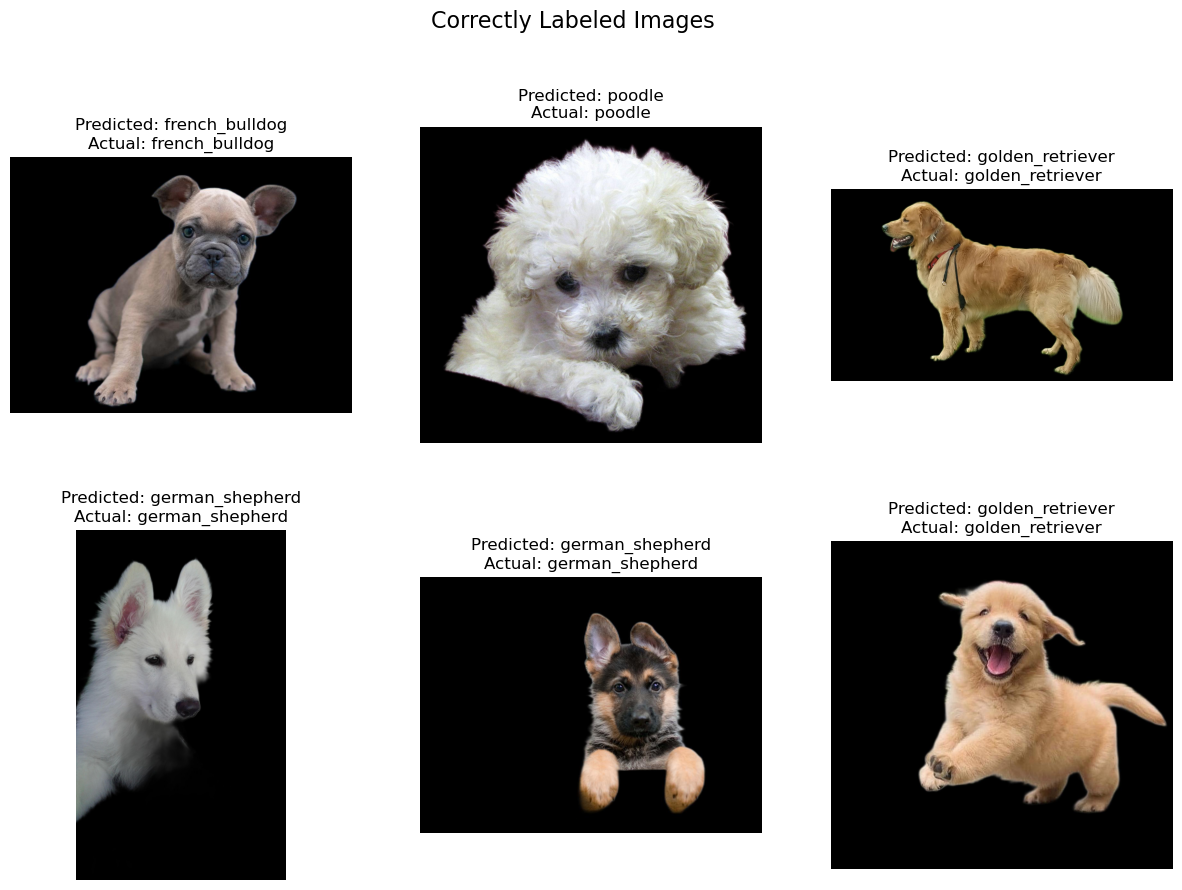

In [41]:
# Function to plot images
def plot_images_1(indices, title):
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16)
    for i, idx in enumerate(indices[:6]):
        img = cv2.imread(paths_test_1[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {label_encoder_C.inverse_transform([y_pred_1[idx]])[0]}\n" +
                  f"Actual: {label_encoder_C.inverse_transform([y_test_1[idx]])[0]}")
    plt.show()

# Display some correctly labeled images
plot_images_1(correct_indices_1,'Correctly Labeled Images')

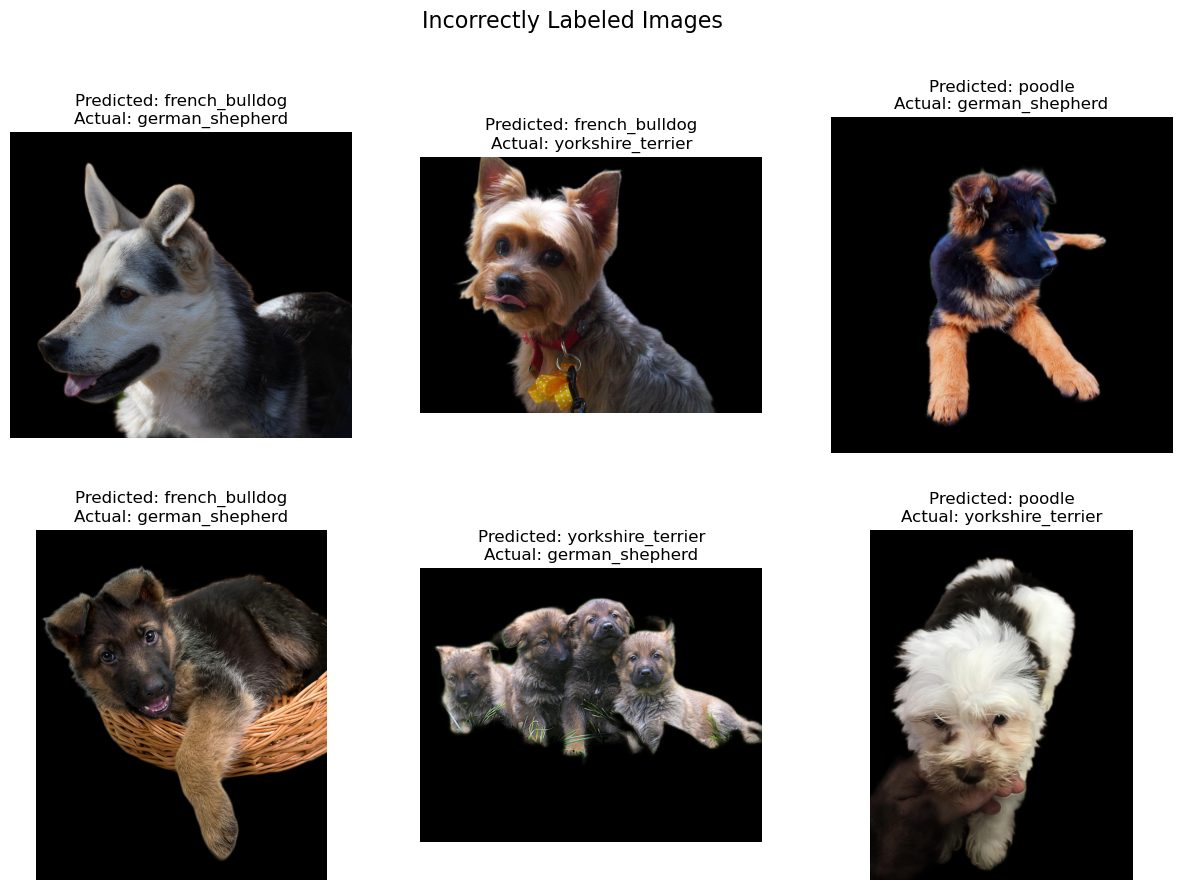

In [42]:
# Display some incorrectly labeled images
plot_images_1(incorrect_indices_1, 'Incorrectly Labeled Images')

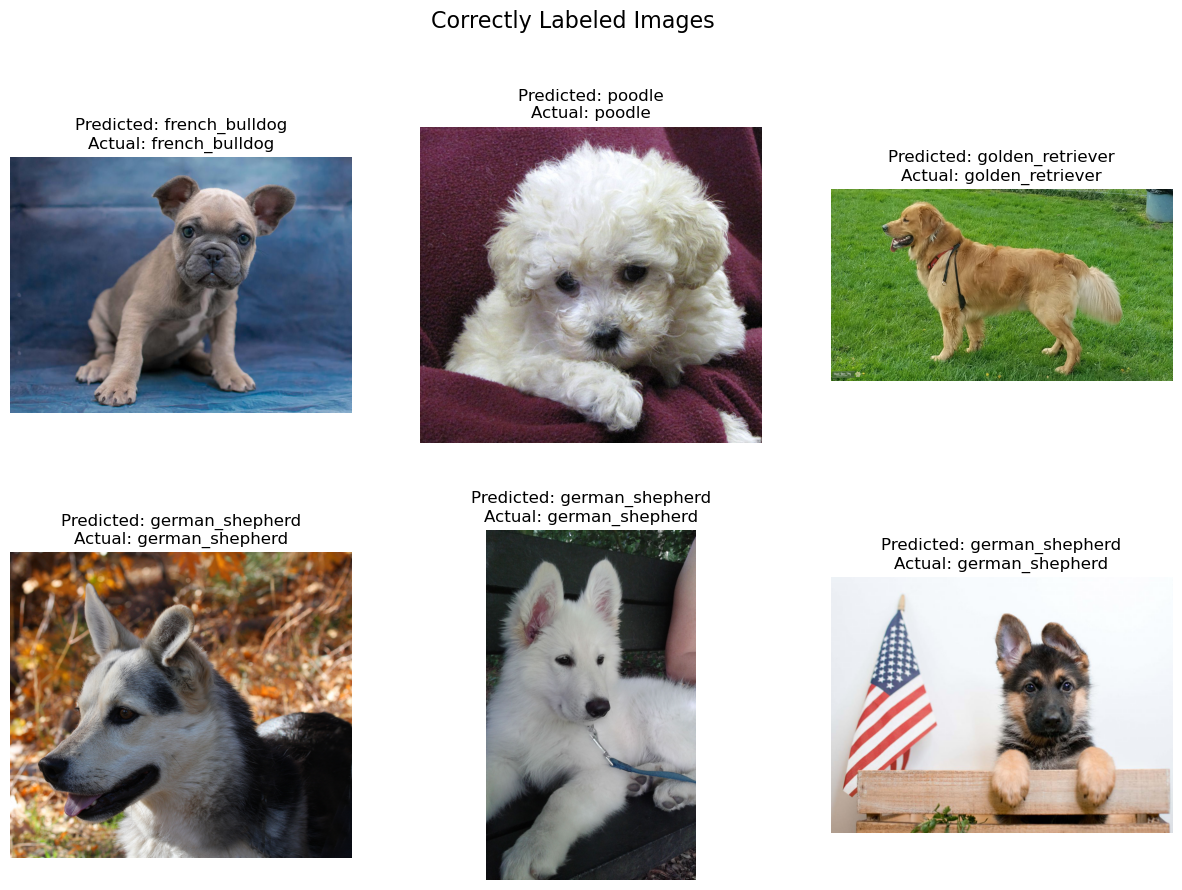

In [34]:
# Function to plot images
def plot_images_2(indices, title):
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16)
    for i, idx in enumerate(indices[:6]):
        img = cv2.imread(paths_test_2[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {label_encoder_BG.inverse_transform([y_pred_2[idx]])[0]}\n" +
                  f"Actual: {label_encoder_BG.inverse_transform([y_test_2[idx]])[0]}")
    plt.show()

# Display some correctly labeled images
plot_images_2(correct_indices,'Correctly Labeled Images')

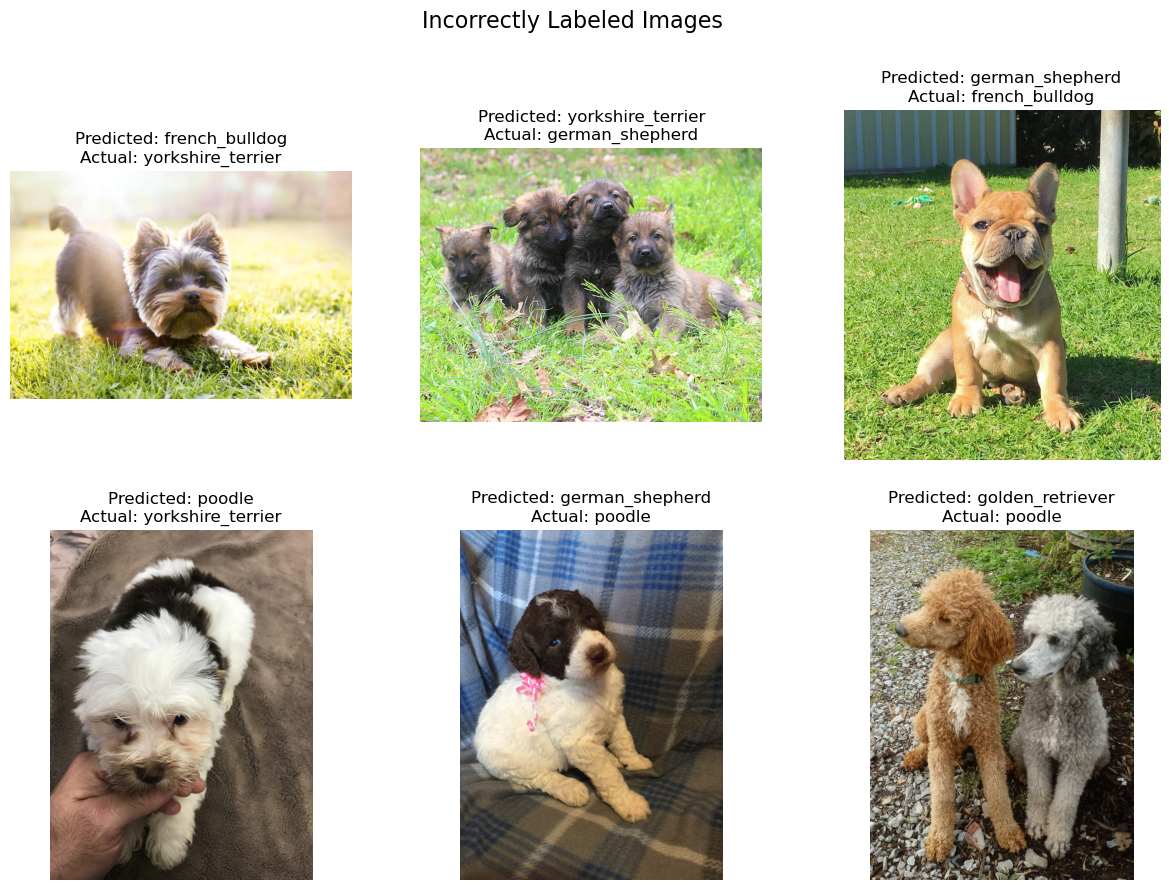

In [35]:
# Display some incorrectly labeled images
plot_images_2(incorrect_indices, 'Incorrectly Labeled Images')